<a href="https://colab.research.google.com/github/Rishabhjuneja/NYC-Taxi/blob/main/exploartion_pyspark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# innstall java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

In [3]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [13]:
from pyspark.sql import functions as F
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from datetime import datetime
from sklearn.cluster import MiniBatchKMeans, KMeans
import warnings
import itertools
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import time
import folium
from folium import Choropleth ,  Circle, Marker

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [21]:
file_loc='./green_tripdata_2016-02.csv'
taxi_data = spark.read.csv(file_loc, inferSchema=True, header =True)

In [6]:
dtaxi_data.show(5)

+--------+--------------------+---------------------+------------------+----------+------------------+------------------+------------------+------------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+----------+
|VendorID|lpep_pickup_datetime|Lpep_dropoff_datetime|Store_and_fwd_flag|RateCodeID|  Pickup_longitude|   Pickup_latitude| Dropoff_longitude|  Dropoff_latitude|Passenger_count|Trip_distance|Fare_amount|Extra|MTA_tax|Tip_amount|Tolls_amount|Ehail_fee|improvement_surcharge|Total_amount|Payment_type|Trip_type |
+--------+--------------------+---------------------+------------------+----------+------------------+------------------+------------------+------------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+----------+
|       2| 2016-02-01 00:00:01|  2016-02-01 00:10:06|                 N| 

In [7]:
dtaxi_data.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- lpep_pickup_datetime: string (nullable = true)
 |-- Lpep_dropoff_datetime: string (nullable = true)
 |-- Store_and_fwd_flag: string (nullable = true)
 |-- RateCodeID: integer (nullable = true)
 |-- Pickup_longitude: double (nullable = true)
 |-- Pickup_latitude: double (nullable = true)
 |-- Dropoff_longitude: double (nullable = true)
 |-- Dropoff_latitude: double (nullable = true)
 |-- Passenger_count: integer (nullable = true)
 |-- Trip_distance: double (nullable = true)
 |-- Fare_amount: double (nullable = true)
 |-- Extra: double (nullable = true)
 |-- MTA_tax: double (nullable = true)
 |-- Tip_amount: double (nullable = true)
 |-- Tolls_amount: double (nullable = true)
 |-- Ehail_fee: string (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- Total_amount: double (nullable = true)
 |-- Payment_type: integer (nullable = true)
 |-- Trip_type : integer (nullable = true)



In [7]:
# check number of rows & Coloums 

print((taxi_data.count(), len(taxi_data.columns)))

(452861, 21)


In [8]:
# Check any missing values 

from pyspark.sql.functions import lit

rows = taxi_data.count()
summary = taxi_data.describe().filter(F.col("summary") == "count")
summary.select(*((F.lit(rows)-F.col(c)).alias(c) for c in taxi_data.columns)).show()

+--------+--------------------+---------------------+------------------+----------+----------------+---------------+-----------------+----------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+----------+
|VendorID|lpep_pickup_datetime|Lpep_dropoff_datetime|Store_and_fwd_flag|RateCodeID|Pickup_longitude|Pickup_latitude|Dropoff_longitude|Dropoff_latitude|Passenger_count|Trip_distance|Fare_amount|Extra|MTA_tax|Tip_amount|Tolls_amount|Ehail_fee|improvement_surcharge|Total_amount|Payment_type|Trip_type |
+--------+--------------------+---------------------+------------------+----------+----------------+---------------+-----------------+----------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+----------+
|     0.0|                 0.0|                  0.0|               0.0|       0.0|             0

In [9]:
# Descriptive Statistics

taxi_data.describe().show()
 

+-------+-------------------+--------------------+---------------------+------------------+------------------+-------------------+------------------+-------------------+------------------+-----------------+------------------+------------------+-------------------+-------------------+------------------+-------------------+---------+---------------------+------------------+------------------+-------------------+
|summary|           VendorID|lpep_pickup_datetime|Lpep_dropoff_datetime|Store_and_fwd_flag|        RateCodeID|   Pickup_longitude|   Pickup_latitude|  Dropoff_longitude|  Dropoff_latitude|  Passenger_count|     Trip_distance|       Fare_amount|              Extra|            MTA_tax|        Tip_amount|       Tolls_amount|Ehail_fee|improvement_surcharge|      Total_amount|      Payment_type|         Trip_type |
+-------+-------------------+--------------------+---------------------+------------------+------------------+-------------------+------------------+-------------------+---

Study: There seems to be outliers in differenet coloums such as ratecodeid , trip distance , fare amount, extra , mat tax should be .5 , trip amount , 

In [25]:
# Check quantile to deepdive check for outliers
pandastaxi_data = taxi_data.toPandas()
pandastaxi_data.quantile(q=0.5, axis=0, numeric_only=True, interpolation='linear')

VendorID                  2.000000
RateCodeID                1.000000
Pickup_longitude        -73.946976
Pickup_latitude          40.746689
Dropoff_longitude       -73.946152
Dropoff_latitude         40.747276
Passenger_count           1.000000
Trip_distance             1.800000
Fare_amount               9.000000
Extra                     0.500000
MTA_tax                   0.500000
Tip_amount                0.000000
Tolls_amount              0.000000
improvement_surcharge     0.300000
Total_amount             11.000000
Payment_type              1.000000
Trip_type                 1.000000
Name: 0.5, dtype: float64

In [25]:
pandas_taxi_data = taxi_data.toPandas()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


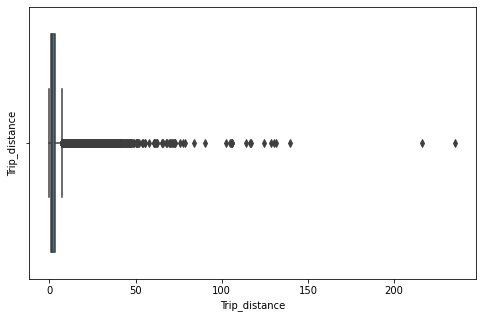

In [37]:
# Plot trip distance to check outliers
plt.figure(figsize = (8,5))
sns.boxplot("Trip_distance", data = pandas_taxi_data, orient = "v")
plt.tick_params(labelsize = 10)
plt.ylabel("Trip_distance", fontsize = 10)
plt.show()

Study: There are some outliers but we should be looked deep into it

In [39]:
# We investigate Quartiles (0-100)
tripDistance_quatile = pandas_taxi_data.Trip_distance.quantile(np.round(np.arange(0.00, 1.01, 0.01), 2))
values_q = np.round(np.arange(0.00, 1.01, 0.1), 2)
for i in values_q:
    print("{} miles are in {} percentile ".format( tripDistance_quatile[i],int(i*100)))

0.0 miles are in 0 percentile 
0.62 miles are in 10 percentile 
0.89 miles are in 20 percentile 
1.13 miles are in 30 percentile 
1.41 miles are in 40 percentile 
1.8 miles are in 50 percentile 
2.3 miles are in 60 percentile 
3.0 miles are in 70 percentile 
4.01 miles are in 80 percentile 
6.05 miles are in 90 percentile 
235.5 miles are in 100 percentile 


90th percentile is 5.98 and 100th is 235.5 so there are outliers and further investigate between 90 to 100

In [41]:
tripDistance_quatile = pandas_taxi_data.Trip_distance.quantile(np.round(np.arange(0.991, 1.001, 0.001), 4))
values_q = np.round(np.arange(0.991, 1.001, 0.001), 3)
for i in values_q:
    print("{} miles are in {} percentile ".format( tripDistance_quatile[i],int(i*100)))

14.37 miles are in 99 percentile 
14.87 miles are in 99 percentile 
15.35 miles are in 99 percentile 
15.939999999999998 miles are in 99 percentile 
16.86 miles are in 99 percentile 
17.7 miles are in 99 percentile 
18.5 miles are in 99 percentile 
19.7 miles are in 99 percentile 
22.79 miles are in 99 percentile 
235.5 miles are in 100 percentile 


Study: since 99.9 percentile is 22.8 and 100 is 235.5, so we will remove anything above 22.8

In [42]:
# Remove data with outliers of trip distance

data_tripdistance=taxi_data.where("Trip_distance < 22.8")

print((data_tripdistance.count(), len(data_tripdistance.columns)))


(1509212, 21)


In [23]:
# Check Fare_amount

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


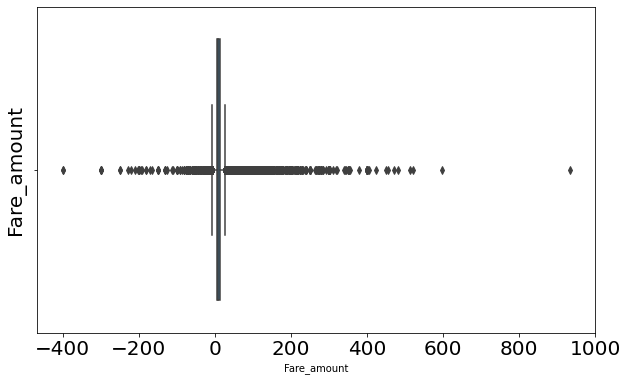

In [26]:
# Plot Fare_amount to check outliers
plt.figure(figsize = (10,6))
sns.boxplot("Fare_amount", data = pandas_taxi_data, orient = "v")
plt.tick_params(labelsize = 20)
plt.ylabel("Fare_amount", fontsize = 20)
plt.show()

Assumption: fare cant be negative so remove them and some outliers also

In [45]:
Fare_amount_quatile = pandas_taxi_data.Fare_amount.quantile(np.round(np.arange(0.00, 1.01, 0.01), 2))
values_q = np.round(np.arange(0.00, 1.01, 0.1), 2)
for i in values_q:
    print("{} miles are in {} percentile ".format( Fare_amount_quatile[i],int(i*100)))

-400.0 miles are in 0 percentile 
4.5 miles are in 10 percentile 
5.5 miles are in 20 percentile 
6.5 miles are in 30 percentile 
7.5 miles are in 40 percentile 
9.0 miles are in 50 percentile 
10.5 miles are in 60 percentile 
13.0 miles are in 70 percentile 
16.5 miles are in 80 percentile 
22.5 miles are in 90 percentile 
933.5 miles are in 100 percentile 


In [46]:
Fare_amount_quatile = pandas_taxi_data.Fare_amount.quantile(np.round(np.arange(0.991, 1.001, 0.001), 3))
values_q = np.round(np.arange(0.991, 1.001, 0.001), 3)
for i in qValues:
    print("{} miles are in {} percentile ".format( Fare_amount_quatile[i],int(i*100)))

48.0 miles are in 99 percentile 
50.0 miles are in 99 percentile 
51.5 miles are in 99 percentile 
52.0 miles are in 99 percentile 
52.0 miles are in 99 percentile 
54.0 miles are in 99 percentile 
58.5 miles are in 99 percentile 
65.0 miles are in 99 percentile 
77.5 miles are in 99 percentile 
933.5 miles are in 100 percentile 


Study: remove anything elow 0 and above 77.5

In [49]:
# Remove data with outliers of fare amount

data_fareamount=data_tripdistance.where("Fare_amount between 0 and 77.5")

print((data_fareamount.count(), len(data_fareamount.columns)))


(1505528, 21)


In [44]:
# Check Total Amount

In [47]:
total_amount_quatile = pandas_taxi_data.Total_amount.quantile(np.round(np.arange(0.00, 1.01, 0.01), 2))
values_q = np.round(np.arange(0.00, 1.01, 0.1), 2)
for i in values_q:
    print("{} miles are in {} percentile ".format( total_amount_quatile[i],int(i*100)))

-400.0 miles are in 0 percentile 
6.3 miles are in 10 percentile 
7.299999999999999 miles are in 20 percentile 
8.3 miles are in 30 percentile 
9.38 miles are in 40 percentile 
11.0 miles are in 50 percentile 
12.8 miles are in 60 percentile 
15.349999999999998 miles are in 70 percentile 
19.3 miles are in 80 percentile 
26.3 miles are in 90 percentile 
1121.16 miles are in 100 percentile 


In [48]:
total_amount_quatile = pandas_taxi_data.Total_amount.quantile(np.round(np.arange(0.991, 1.001, 0.001), 3))
values_q = np.round(np.arange(0.991, 1.001, 0.001), 3)
for i in qValues:
    print("{} miles are in {} percentile ".format( total_amount_quatile[i],int(i*100)))

54.36 miles are in 99 percentile 
56.3 miles are in 99 percentile 
58.3 miles are in 99 percentile 
60.0 miles are in 99 percentile 
62.88 miles are in 99 percentile 
66.34 miles are in 99 percentile 
70.01 miles are in 99 percentile 
76.0 miles are in 99 percentile 
92.20999999999998 miles are in 99 percentile 
1121.16 miles are in 100 percentile 


Study: Remove anything below 0 and above 92.2

In [50]:
# Remove data with outliers of trip distance

data_distance=data_tripdistance.where("Total_amount between 0 and  22.8")

print((data_distance.count(), len(data_distance.columns)))


(1297720, 21)


In [51]:
# Remove other outliers such as ratecodeid can't be >6 , MTA tax is 0.5, imrovement chargers is 0.3

taxi_data_no_outlier=data_distance.where("RateCodeID < 7").where("MTA_tax  = 0.5").where("improvement_surcharge = 0.3")


print((taxi_data_no_outlier.count(), len(taxi_data_no_outlier.columns)))


(1269864, 21)


Could have looked into other abnormalities like lat and long

In [52]:
# get date and time coloum seprately for pickup and drop
from pyspark.sql import functions as F

split_col = F.split(taxi_data_no_outlier['lpep_pickup_datetime'], ' ')
split_col2 = F.split(taxi_data_no_outlier['Lpep_dropoff_datetime'], ' ')
taxi_data_no_outlier = taxi_data_no_outlier.withColumn('pickup_date', split_col.getItem(0)).withColumn('pickup_time', split_col.getItem(1)).withColumn('drop_date', split_col2.getItem(0)).withColumn('drop_time', split_col2.getItem(1))


taxi_data_no_outlier.show(5)

+--------+--------------------+---------------------+------------------+----------+------------------+------------------+------------------+------------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+----------+-----------+-----------+----------+---------+
|VendorID|lpep_pickup_datetime|Lpep_dropoff_datetime|Store_and_fwd_flag|RateCodeID|  Pickup_longitude|   Pickup_latitude| Dropoff_longitude|  Dropoff_latitude|Passenger_count|Trip_distance|Fare_amount|Extra|MTA_tax|Tip_amount|Tolls_amount|Ehail_fee|improvement_surcharge|Total_amount|Payment_type|Trip_type |pickup_date|pickup_time| drop_date|drop_time|
+--------+--------------------+---------------------+------------------+----------+------------------+------------------+------------------+------------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+--------

In [53]:
taxi_data_no_outlier_pandas = taxi_data_no_outlier.toPandas()

In [57]:
#Cluster example
cluster = taxi_data_no_outlier_pandas.loc[0]
#Feature Engineering
cluster['lpep_pickup_datetime'] = cluster.index
cluster['lpep_pickup_datetime'] = pd.to_datetime(cluster['lpep_pickup_datetime'].dt.strftime('%Y-%m-%d %H'))
#cluster['hour']=cluster['lpep_pickup_datetime'].dt.hour 
#cluster['day']=cluster['lpep_pickup_datetime'].dt.day
#cluster['dayofweek']=cluster['lpep_pickup_datetime'].dt.dayofweek 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


AttributeError: ignored